

## Uso del aprendizaje automático para predecir el consumo de energía


![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

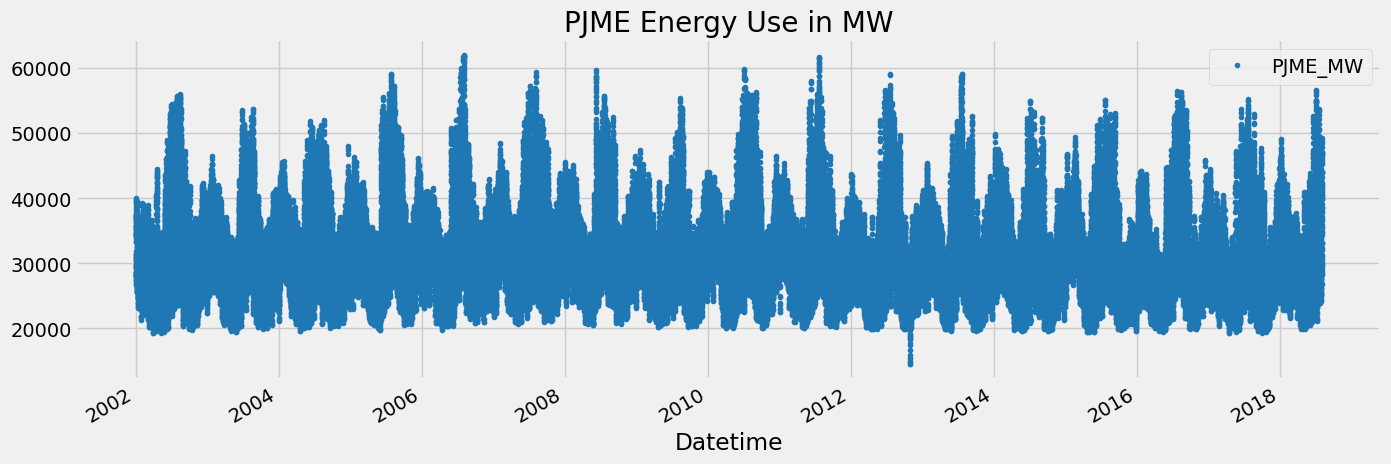

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# 1. **Análisis de outliers o datos incompletos**

<Axes: ylabel='Frequency'>

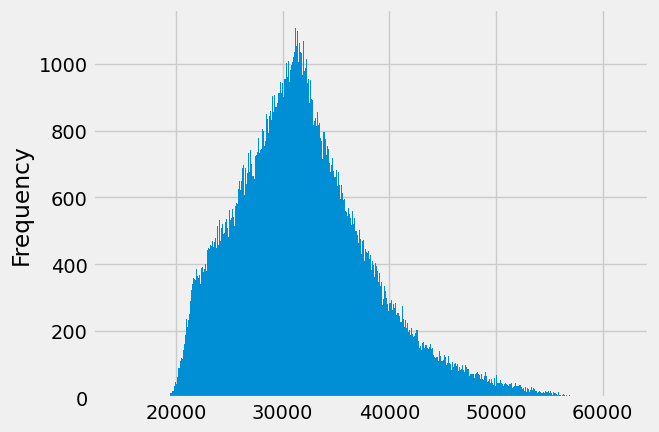

In [4]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

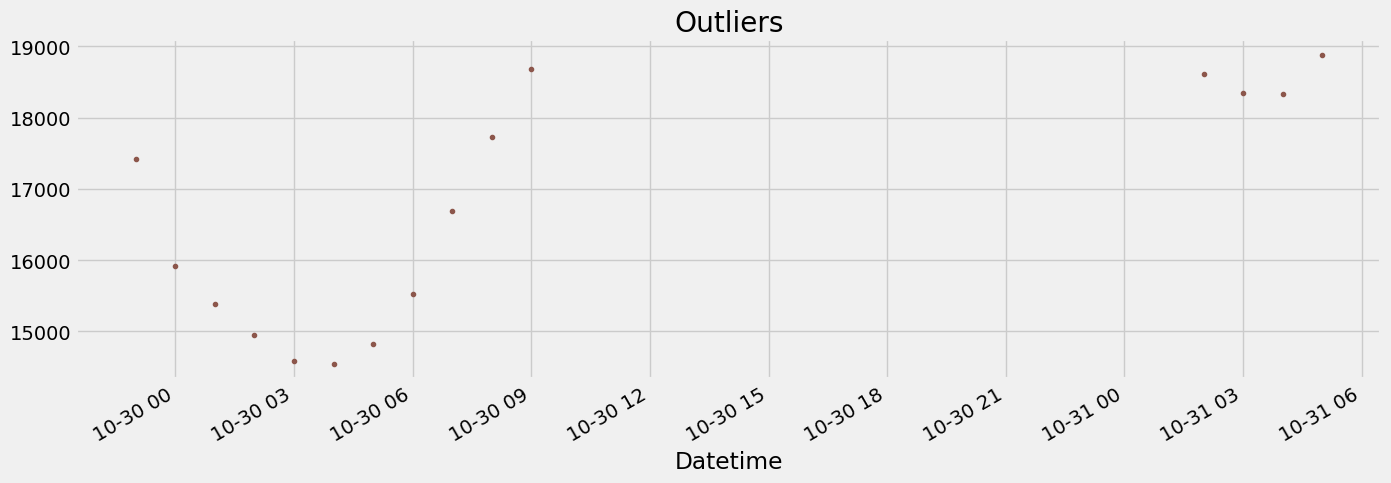

In [5]:
# Outliers
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [6]:
# Removiendo outliers
df = df.query('PJME_MW > 19_000').copy()

# Train / Test Split

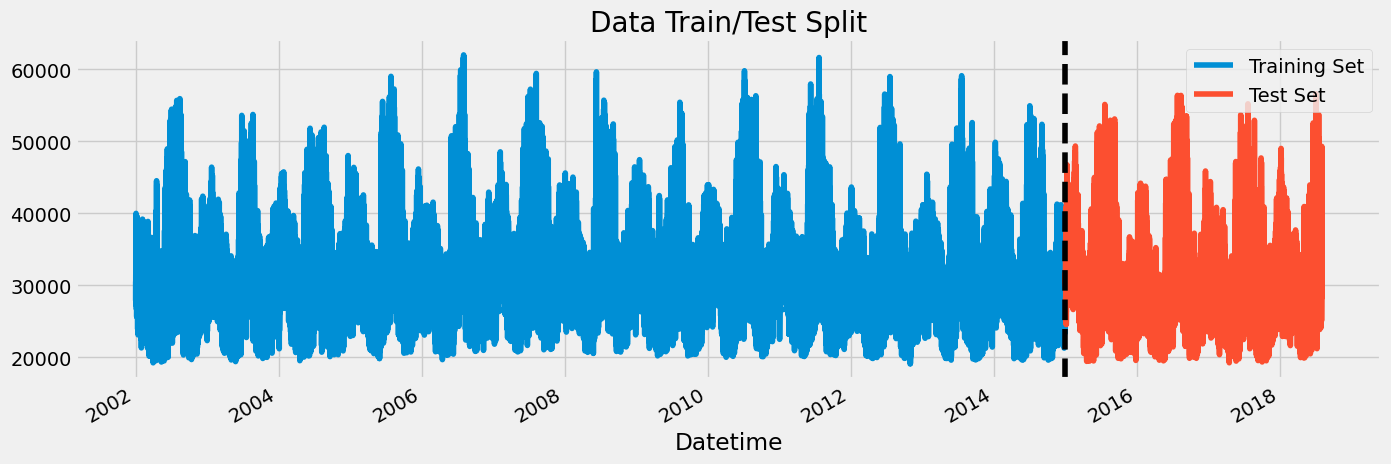

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

La función TimeSeriesSplit de scikit-learn se usa para dividir datos de series temporales en conjuntos de entrenamiento y prueba, respetando el orden temporal.

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()
df

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


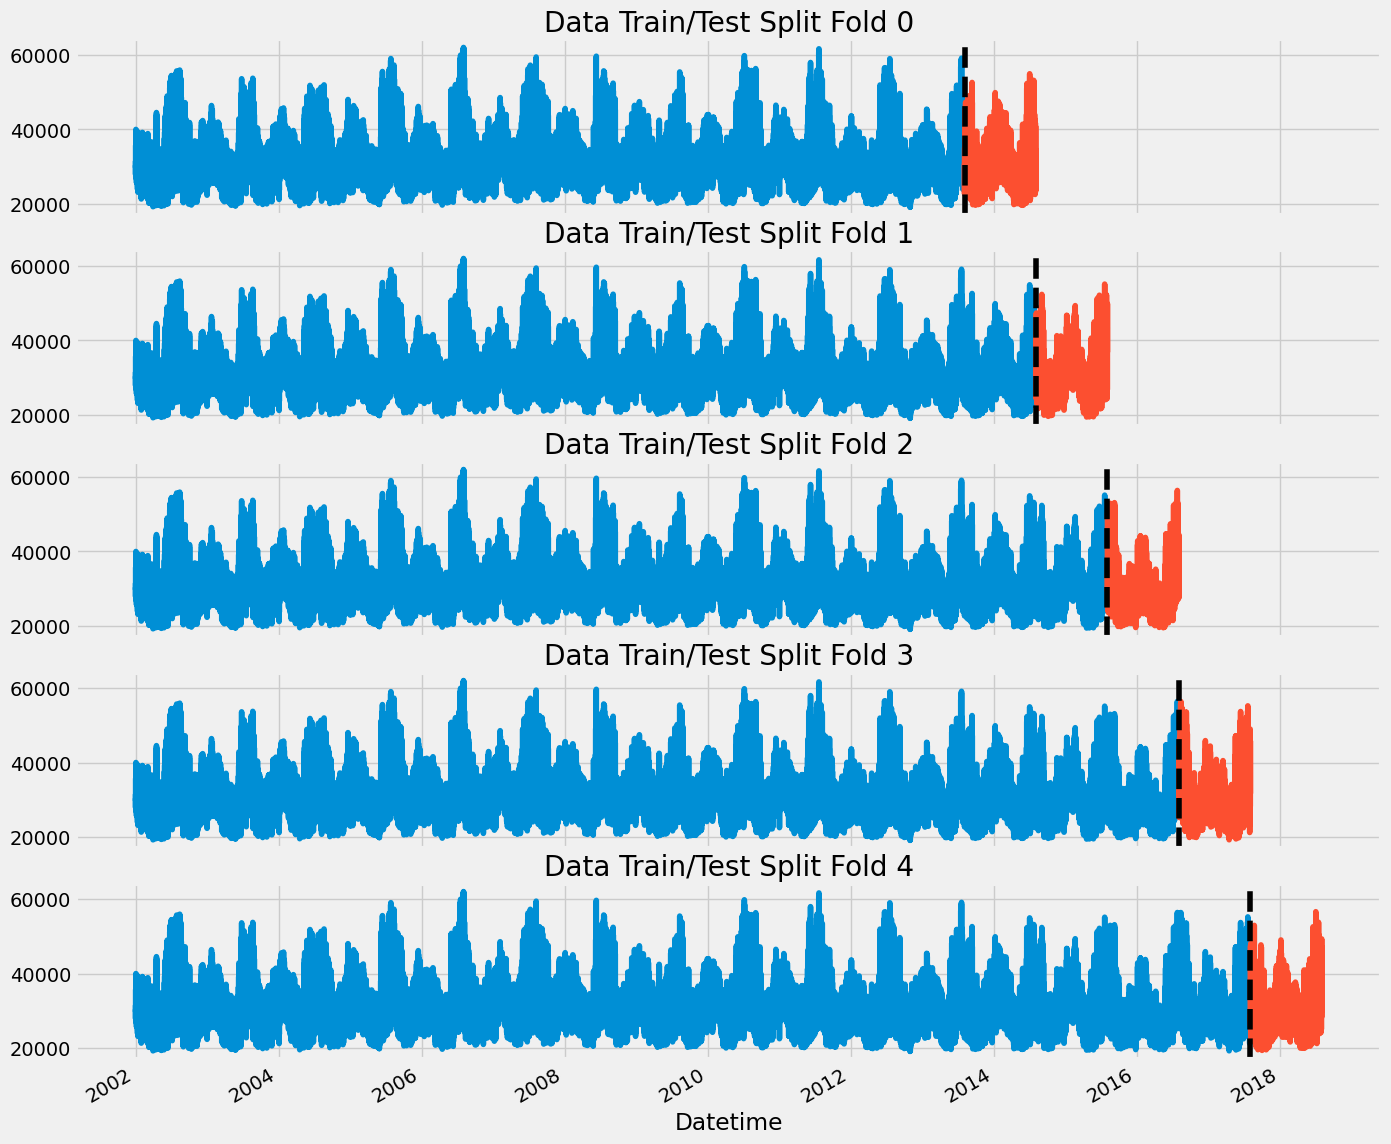

In [124]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Explicación del horizonte de previsión
El horizonte de previsión es el periodo de tiempo futuro para el que se elaboran las previsiones. Suele variar desde horizontes de previsión a corto plazo (menos de tres meses) hasta horizontes a largo plazo (más de dos años).

In [9]:
def create_features(df):
    """
    Creamos las features características de las seríes de tiempo.
    """
# Temporal Features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # # Rolling Statistics
    # df['rolling_mean_24h'] = df['PJME_MW'].rolling(window=24).mean()
    # df['rolling_std_24h'] = df['PJME_MW'].rolling(window=24).std()
    # df['rolling_mean_7d'] = df['PJME_MW'].rolling(window=24*7).mean()
    # df['rolling_std_7d'] = df['PJME_MW'].rolling(window=24*7).std()
    
    # # Exponential Weighted Mean (EWM)
    # df['ewm_24h'] = df['PJME_MW'].ewm(span=24).mean()
    # df['ewm_7d'] = df['PJME_MW'].ewm(span=24*7).mean()
    
    # # Fourier Features for Seasonality
    # df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    # df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    # df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
    # df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)
    
    return df

df = create_features(df)

# 3. Lag Features
- Cuál era el objetivo (x) días antes.

In [10]:
def add_lags(df):
    df = df.copy()  # Para evitar modificar el DataFrame original
    df['lag1'] = df['PJME_MW'].shift(365) # desplazamiento de 365 días
    df['lag2'] = df['PJME_MW'].shift(730) # desplazamiento de 365 días
    df['lag3'] = df['PJME_MW'].shift(1095) # desplazamiento de 365 días
    return df


In [11]:
df = add_lags(df)

## Train Using Cross Validation

In [12]:
# Configuración del TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()  # Asegurar que el índice está ordenado

FEATURES = df.drop('PJME_MW',axis=1).columns
TARGET = 'PJME_MW'

# Listas para almacenar predicciones y puntuaciones
preds, scores = [], []

def train_and_evaluate(train_idx, val_idx, df):
    """Función para entrenar y evaluar un modelo en un fold específico."""
    train, test = df.iloc[train_idx].copy(), df.iloc[val_idx].copy()  # 🚀 Solución: usar .copy()
    
    # Crear características y rezagos
    train = create_features(train)
    test = create_features(test)
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]
    
    # Definir el modelo XGBoost
    reg = xgb.XGBRegressor(
        base_score=0.5, 
        booster='gbtree',
        n_estimators=1000, 
        early_stopping_rounds=50,
        objective='reg:squarederror', 
        max_depth=3, 
        learning_rate=0.01
    )
    
    # Entrenar el modelo
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    
    # Generar predicciones
    y_pred = reg.predict(X_test)
    
    # Evaluar el modelo
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return y_pred, score


# Loop sobre cada fold
for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
    y_pred, score = train_and_evaluate(train_idx, val_idx, df)
    preds.append(y_pred)
    scores.append(score)

# Imprimir métricas de evaluación
print(f"RMSE promedio: {np.mean(scores):.4f}, desviación estándar: {np.std(scores):.4f}")


[0]	validation_0-rmse:32733.86759	validation_1-rmse:31957.26765
[100]	validation_0-rmse:12610.79911	validation_1-rmse:11961.42256
[200]	validation_0-rmse:5826.84563	validation_1-rmse:5417.53576
[300]	validation_0-rmse:3894.24631	validation_1-rmse:3880.84988
[400]	validation_0-rmse:3433.76330	validation_1-rmse:3715.87047
[500]	validation_0-rmse:3291.26969	validation_1-rmse:3687.82106
[600]	validation_0-rmse:3206.93404	validation_1-rmse:3674.43564
[700]	validation_0-rmse:3148.37858	validation_1-rmse:3660.02042
[751]	validation_0-rmse:3124.83742	validation_1-rmse:3664.75956
[0]	validation_0-rmse:32673.57712	validation_1-rmse:32139.96609
[100]	validation_0-rmse:12598.79743	validation_1-rmse:12170.66273
[200]	validation_0-rmse:5840.06270	validation_1-rmse:5590.18528
[300]	validation_0-rmse:3919.85362	validation_1-rmse:3999.93970
[400]	validation_0-rmse:3464.27235	validation_1-rmse:3742.14054
[500]	validation_0-rmse:3320.39980	validation_1-rmse:3638.69589
[600]	validation_0-rmse:3235.38884	v

In [13]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3681.2260
Fold scores:[np.float64(3659.4217386586597), np.float64(3481.6544400976195), np.float64(3506.0458090343236), np.float64(3833.600603683712), np.float64(3925.4071857062595)]


# 4. Calculamos el pronóstico
- Reentrenamiento en todos los datos
- Para predecir el futuro necesitamos un dataframe vacío para los rangos de fechas futuras.
- Ejecutar esas fechas a través de nuestro código de creación de características + creación de lag

In [14]:
# Reentrenamos todos los datos
df = create_features(df)

FEATURES = df.drop('PJME_MW',axis=1).columns
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32405.46790
[100]	validation_0-rmse:12543.72818
[200]	validation_0-rmse:5871.87430
[300]	validation_0-rmse:4015.79020
[400]	validation_0-rmse:3571.48202
[499]	validation_0-rmse:3430.13934


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
# Creamos las fechas futuras
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [18]:
future_w_features = df_and_future.query('isFuture').copy()

## Generando las predicciones

In [19]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

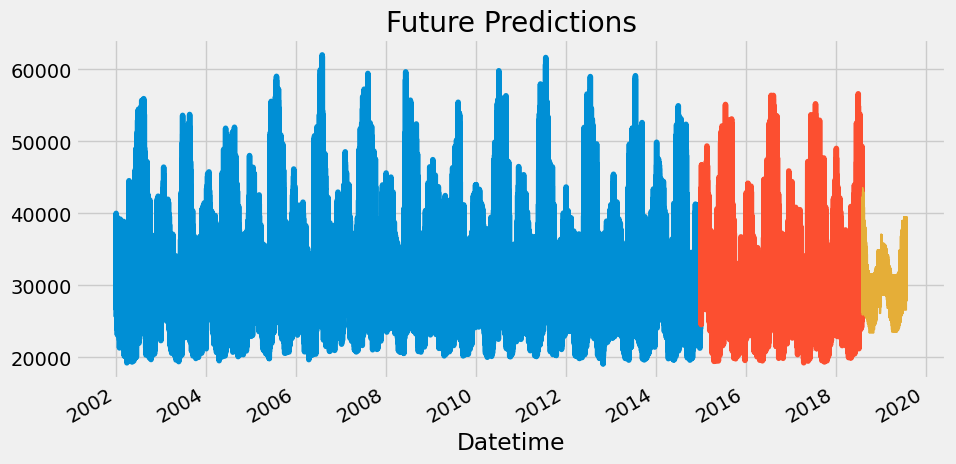

In [20]:
train['PJME_MW'].plot( label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot( label='Test Set')
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()


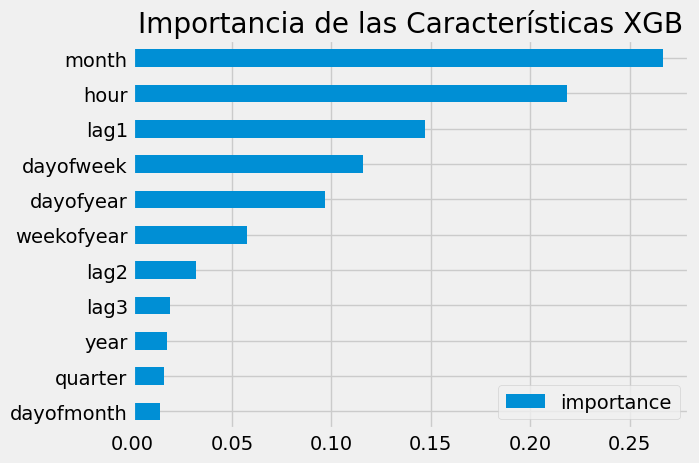

In [21]:
#Anlizando por feature importance
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Importancia de las Características XGB')
plt.show()

# Bonus: Guardamos el modelo para usarlo posteriormente

In [24]:
# Save model
reg.save_model('model.json')

In [25]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

AttributeError: 'super' object has no attribute '__sklearn_tags__'